In [35]:
!pip install qiskit

In [36]:
!pip install qiskit_aer

In [37]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
#from qiskit.providers.aer.noise import NoiseModel
#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
import numpy as np
from typing import List, Optional, Dict
from abc import ABC, abstractmethod

In [38]:
class BaseQRNG(ABC):
    """Abstract base class for quantum random number generators."""
    def __init__(self, backend='AerSimulator'):
        self.backend = AerSimulator()

    @abstractmethod
    def generate_number(self, max_value: int) -> int:
        pass

In [39]:
class BitStreamQRNG(BaseQRNG):
    """
    Generates random numbers by building them bit by bit.
    Uses only 1 qubit but multiple measurements.
    """
    def __init__(self, backend='AerSimulator'):
        super().__init__(backend)

    def generate_number(self, max_value: int) -> int:
        # Calculate number of bits needed
        num_bits = (max_value - 1).bit_length()

        # Create circuit for single qubit
        qr = QuantumRegister(1)
        cr = ClassicalRegister(1)
        circuit = QuantumCircuit(qr, cr)

        result = 0
        for i in range(num_bits):
            # Reset circuit
            circuit.reset(qr)
            # Apply Hadamard gate
            circuit.h(0)
            # Measure
            circuit.measure(qr, cr)

            # Execute circuit
            compiled_circuit = transpile(circuit, self.backend)
            sim_result = self.backend.run(compiled_circuit).result()
            counts = sim_result.get_counts()
            bit = int(list(counts.keys())[0])

            # Build number bit by bit
            result = (result << 1) | bit

        # If result is larger than max_value, try again
        return result % (max_value + 1)

In [40]:
class ChunkedQRNG(BaseQRNG):
    """
    Uses a small number of qubits multiple times to build larger numbers.
    More efficient than bit-by-bit but still manageable qubit count.
    """
    def __init__(self, chunk_size: int = 3, backend='AerSimulator'):
        super().__init__(backend)
        self.chunk_size = chunk_size

    def generate_number(self, max_value: int) -> int:
        # Calculate number of chunks needed
        bits_needed = (max_value - 1).bit_length()
        chunks_needed = (bits_needed + self.chunk_size - 1) // self.chunk_size

        # Create circuit
        qr = QuantumRegister(self.chunk_size)
        cr = ClassicalRegister(self.chunk_size)
        circuit = QuantumCircuit(qr, cr)

        result = 0
        for _ in range(chunks_needed):
            # Reset circuit
            circuit.reset(qr)
            # Apply Hadamard gates
            for i in range(self.chunk_size):
                circuit.h(i)
            # Measure
            circuit.measure(qr, cr)

            # Execute circuit
            compiled_circuit = transpile(circuit, self.backend)
            sim_result = self.backend.run(compiled_circuit).result()
            counts = sim_result.get_counts()
            chunk = int(list(counts.keys())[0], 2)

            # Build number chunk by chunk
            result = (result << self.chunk_size) | chunk

        return result % (max_value + 1)

In [41]:
class NormalQRNG(BaseQRNG):
    """
    Uses the exact number of qubits required to generate all the numbers.
    Less manageable qubit count though measurement runs are less.
    """
    def __init__(self, backend='AerSimulator'):
        super().__init__(backend)

    def generate_number(self, max_value: int) -> int:
        # Calculate number of chunks needed
        bits_needed = (max_value - 1).bit_length()

        i=0
        x = 0
        while bits_needed>x:
          i+=1
          x = 2**i


        # Create circuit
        qr = QuantumRegister(i)
        cr = ClassicalRegister(i)
        circuit = QuantumCircuit(qr, cr)

        for j in range(i):
          circuit.h(j)

        circuit.measure(qr, cr)
        result = 0
        # Execute circuit
        compiled_circuit = transpile(circuit, self.backend)
        sim_result = self.backend.run(compiled_circuit).result()
        counts = sim_result.get_counts()
        output = int(list(counts.keys())[0], 2)

        return output % (max_value + 1)

In [42]:
def compare_generators(max_value: int = 1000, num_samples: int = 1000, bin_size: int = 10000):
    generators = {
        "BitStream": BitStreamQRNG(),
        "Chunked": ChunkedQRNG(chunk_size=3),
        "Normal":NormalQRNG()
    }

    results = {}
    bin_counts = {}  # Dictionary to store bin counts for each generator
    bin_ranges = {}  # Dictionary to store bin ranges

    for name, generator in generators.items():
        numbers = [generator.generate_number(max_value) for _ in range(num_samples)]
        results[name] = {
            "mean": np.mean(numbers),
            "std": np.std(numbers),
            "min": min(numbers),
            "max": max(numbers)
        }

        # Create bins and label ranges
        bins = np.arange(0, max_value + bin_size, bin_size)
        bin_ranges[name] = [(bins[i], bins[i + 1] - 1) for i in range(len(bins) - 1)]

        # Bin the numbers into bins of size bin_size
        bin_indices = np.digitize(numbers, bins)  # Determine the bin for each number
        bin_counts[name] = np.bincount(bin_indices, minlength=len(bins))

    return results, numbers, bin_counts, bin_ranges


In [43]:
import matplotlib.pyplot as plt
def plot_bin_counts_with_ranges(bin_ranges, bin_counts, title="Bin Counts vs. Bin Ranges"):
    # Create the bin range labels (e.g., '0-9999', '10000-19999', etc.)
    bin_labels = [f"{low}-{high}" for (low, high) in bin_ranges]

    # Set up the figure and plot the bin counts
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(bin_labels)), bin_counts[1:], marker='o', linestyle='-', color='b')  # Skip the first bin if it's unused

    # Set the x-axis ticks to the bin range labels
    plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=90)

    # Label the axes
    plt.xlabel("Bin Ranges")
    plt.ylabel("Bin Counts")
    plt.title(title)

    # Show the plot
    plt.tight_layout()  # Adjust layout so that x-labels are not cut off
    plt.grid(True)
    plt.show()

Generating random numbers between 0 and 10000
BitStream: 1323
Chunked: 7004
Normal: 15

Analyzing distributions and binning numbers...

BitStream Statistics:
  mean: 4115.06
  std: 2941.88
  min: 57.00
  max: 9995.00

Chunked Statistics:
  mean: 5413.51
  std: 2544.13
  min: 387.00
  max: 9816.00

Normal Statistics:
  mean: 8.54
  std: 5.17
  min: 0.00
  max: 15.00

BitStream Bin Counts:
  Range 0 - 999: 24 numbers
  Range 1000 - 1999: 11 numbers
  Range 2000 - 2999: 6 numbers
  Range 3000 - 3999: 7 numbers
  Range 4000 - 4999: 11 numbers
  Range 5000 - 5999: 13 numbers
  Range 6000 - 6999: 8 numbers
  Range 7000 - 7999: 8 numbers
  Range 8000 - 8999: 5 numbers
  Range 9000 - 9999: 7 numbers

Chunked Bin Counts:
  Range 0 - 999: 5 numbers
  Range 1000 - 1999: 7 numbers
  Range 2000 - 2999: 9 numbers
  Range 3000 - 3999: 14 numbers
  Range 4000 - 4999: 6 numbers
  Range 5000 - 5999: 12 numbers
  Range 6000 - 6999: 11 numbers
  Range 7000 - 7999: 21 numbers
  Range 8000 - 8999: 9 numbers

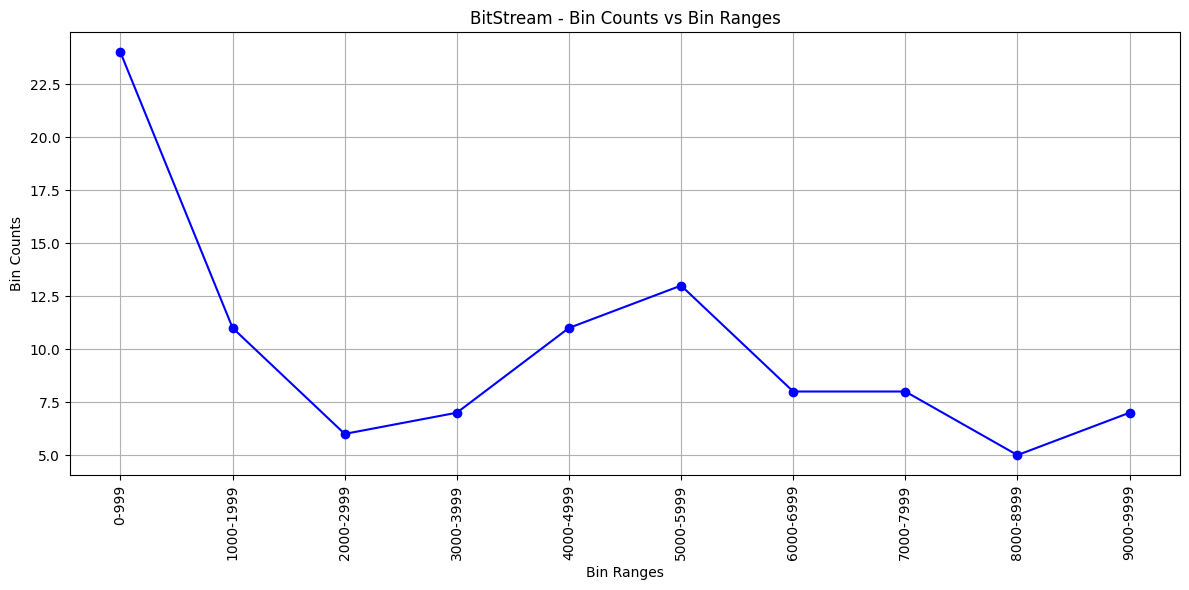


Plotting Chunked Bin Counts:


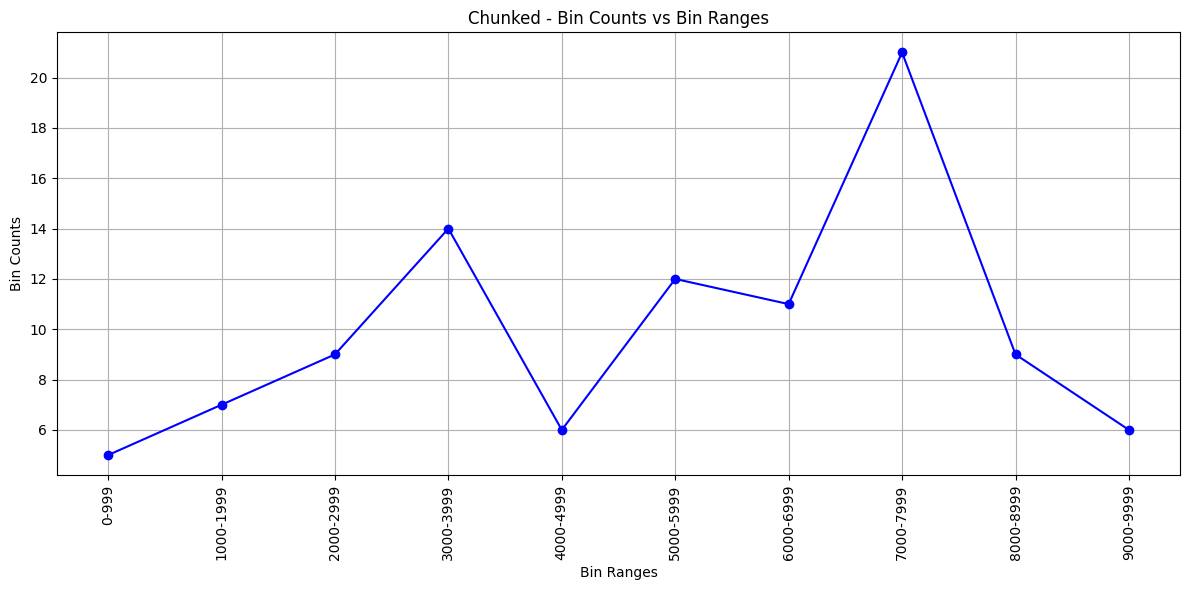


Plotting Normal Bin Counts:


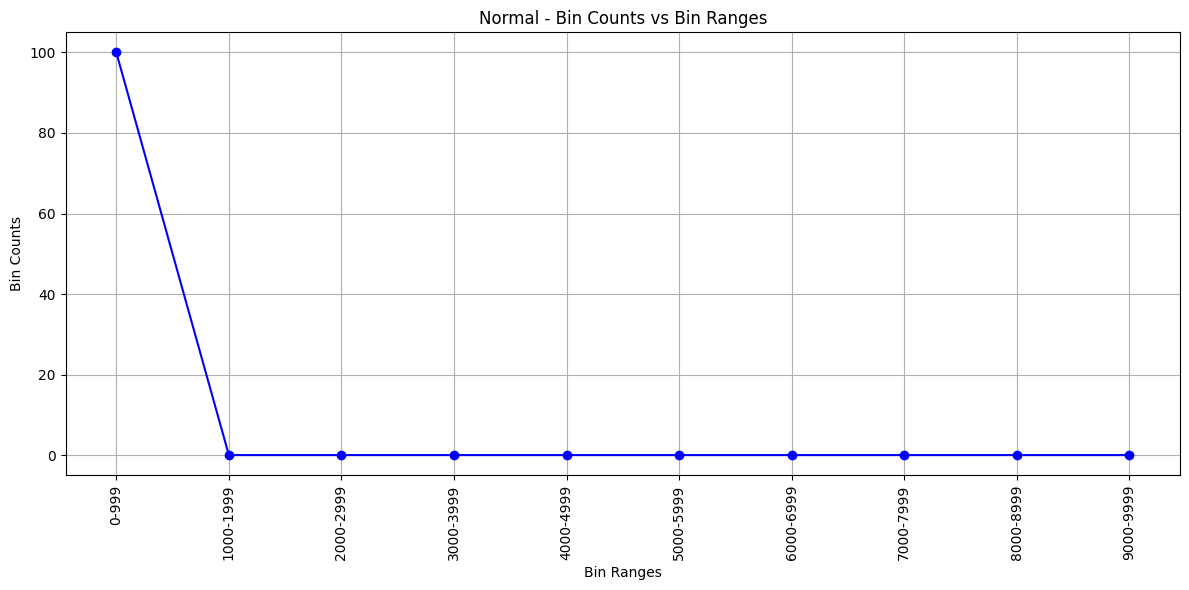

In [44]:
if __name__ == "__main__":
    # Generate a random number using each method
    max_value = 10000
    bin_size = 1000
    generators = {
        "BitStream": BitStreamQRNG(),
        "Chunked": ChunkedQRNG(chunk_size=3),
        "Normal":NormalQRNG()
    }

    print("Generating random numbers between 0 and", max_value)
    for name, generator in generators.items():
        number = generator.generate_number(max_value)
        print(f"{name}: {number}")

    # Compare distributions and bin the numbers
    print("\nAnalyzing distributions and binning numbers...")
    results, numbers, bin_counts, bin_ranges = compare_generators(max_value=max_value, num_samples=100, bin_size=bin_size)

    for name, stats in results.items():
        print(f"\n{name} Statistics:")
        for stat_name, value in stats.items():
            print(f"  {stat_name}: {value:.2f}")

    # Print bin counts with labeled ranges
    for name, counts in bin_counts.items():
        print(f"\n{name} Bin Counts:")
        for bin_index, count in enumerate(counts[1:], start=1):  # Skip the 0 bin as it's outside our valid range
            bin_range = bin_ranges[name][bin_index - 1]  # Get the corresponding range for each bin
            print(f"  Range {bin_range[0]} - {bin_range[1]}: {count} numbers")

    for name, counts in bin_counts.items():
        print(f"\nPlotting {name} Bin Counts:")
        plot_bin_counts_with_ranges(bin_ranges[name], counts, title=f"{name} - Bin Counts vs Bin Ranges")
